<a id="0"></a>
# <b style="font-family: Verdana" id="imports">CONFIGURATION</b>

In [1]:
class cfg:
    IMAGE_SIZE = 128

    # Data Augmentation
    BRIGHTNESS = (0.64, 1.37) # (MIN, MAX)
    CONTRAST   = (0.64, 1.37) # (MIN, MAX)

    # Train-Val Split
    TRAIN_VAL_SPLIT = 0.8 # 80% of all the samples are used for training, and the rest for validation

    # Model Training
    BATCH_SIZE = 1
    EPOCHS = 1
    LEARNING_RATE = 0.00008

<a id="1"></a>
# <b style="font-family: Verdana">1 <span style='color:#43B0C1'>|</span> SETUP</b>
- **For ML Models**: tensorflow, keras
- **For Data Manipulation & Processing**: numpy, sklearn, PIL
- **For Data Visualization**: matplotlib, seaborn, plotly

In [2]:
# Miscellaneous
from tqdm import tqdm
import random
import os
import time
# Turn off tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

# For Data Processing & ML Models
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image, ImageEnhance
import cv2

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# Enable offline usage of plotly
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

from IPython.display import clear_output
clear_output()

Setting a seed so that you can get similar results as mine 😃

In [3]:
tf.random.set_seed(100)
np.random.seed(100)

In [4]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


<a id="2"></a>
# <b style="font-family: Verdana">2 <span style='color:#43B0C1'>|</span> EXPLORING THE DATASET</b>

This is the dataset structure
```bash
├── chest-xray-pneumoniacovid19tuberculosis
│   ├── test
│   │   ├── COVID19
│   │   │   └── ...
│   │   ├── NORMAL
│   │   │   ├── ...
│   │   ├── PNEUMONIA
│   │   │   └── ...
│   │   ├── TURBERCULOSIS
│   │   │   └── ...
│   ├── train
│   │   ├── COVID19
│   │   │   └── ...
│   │   ├── NORMAL
│   │   │   └── ...
│   │   ├── PNEUMONIA
│   │   │   └── ...
│   │   ├── TURBERCULOSIS
│   │   │   └── ...
│   ├── val
│   │   ├── COVID19
│   │   │   └── ...
│   │   ├── NORMAL
│   │   │   └── ...
│   │   ├── PNEUMONIA
│   │   │   └── ...
│   │   └── TURBERCULOSIS
            └── ...
```
The images are already separated for training & validation, but I want to separate the data by a different amount.  
So, here I am creating a dataframe with two columns, one containing the path to an image, and the other for the label.   
[Also, I'm fixing the typo in turberculosis]

In [5]:


data_directories = ["C:\\Users\\acer\\OneDrive\\Desktop\\archive\\test\\",
                    "C:\\Users\\acer\\OneDrive\\Desktop\\archive\\train\\",
                    "C:\\Users\\acer\\OneDrive\\Desktop\\archive\\val\\"]

all_paths = []
all_labels = []

for data_dir in data_directories:
    for label in os.listdir(data_dir):
        for image in os.listdir(data_dir+label):
            all_paths.append(data_dir+label+'/'+image)
            if label=='TURBERCULOSIS':
                all_labels.append('TUBERCULOSIS')
            else:
                all_labels.append(label)

all_paths, all_labels = shuffle(all_paths, all_labels)

pd.set_option('display.max_colwidth', None)
df = pd.DataFrame({'path':all_paths, 'label':all_labels})
df

,path,label
0,C:\Users\acer\OneDrive\Desktop\archive\train\NORMAL/NORMAL2-IM-0799-0001.jpeg,NORMAL
1,C:\Users\acer\OneDrive\Desktop\archive\train\PNEUMONIA/person1036_bacteria_2970.jpeg,PNEUMONIA
2,C:\Users\acer\OneDrive\Desktop\archive\train\PNEUMONIA/person1474_virus_2556.jpeg,PNEUMONIA
3,C:\Users\acer\OneDrive\Desktop\archive\train\PNEUMONIA/person1550_virus_2691.jpeg,PNEUMONIA
4,C:\Users\acer\OneDrive\Desktop\archive\train\TURBERCULOSIS/Tuberculosis-530.png,TUBERCULOSIS
...,...,...
7130,C:\Users\acer\OneDrive\Desktop\archive\test\COVID19/COVID19(539).jpg,COVID19
7131,C:\Users\acer\OneDrive\Desktop\archive\train\PNEUMONIA/person1634_bacteria_4331.jpeg,PNEUMONIA
7132,C:\Users\acer\OneDrive\Desktop\archive\train\PNEUMONIA/person721_virus_1340.jpeg,PNEUMONIA
7133,C:\Users\acer\OneDrive\Desktop\archive\train\TURBERCULOSIS/Tuberculosis-54.png,TUBERCULOSIS


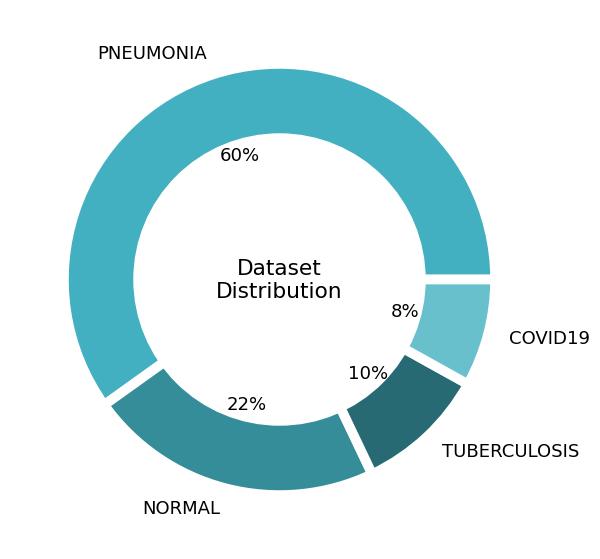

In [6]:
plt.rcParams.update({'font.size': 13})

plt.figure(figsize=(7,7))

# plotting data on chart
plt.pie(list(df.label.value_counts()),
        labels=list(df.label.value_counts().index),
        colors=['#43b0c1', '#368d9a', '#286a74', '#69c0cd'],
        autopct='%.0f%%', wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })

my_circle=plt.Circle((0,0), 0.675, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Dataset\nDistribution', x=0.5, y=0.45) 
plt.show()

<a id="3.1"></a>
<h2 style="font-family: Verdana">3.1 <span style='color:#43B0C1; font-weight: bold;'>|</span> Image Data Augmentation</h2>  

Image Augmentation is a process that is used to create new images for training by slightly altering the pixel values.  
We have a small dataset, so we can apply some image augmentation techniques to prevent overfitting of the model.   
Techniques we will be using are:  
- Change the brightness of an image by a factor between 0.67 to 1.33
- Change the contrast of an image by a factor between 0.67 to 1.33  

[The factors are defined in the configuration section]

In [7]:
def augment_image(image):
    # Convert input image from numpy to PIL Image
    image = Image.fromarray(np.uint8(image)) 
    # Select brightness and contrast factors
    brightness_factor = random.uniform(cfg.BRIGHTNESS[0],cfg.BRIGHTNESS[1])
    contrast_factor = random.uniform(cfg.CONTRAST[0],cfg.CONTRAST[1])
    # Apply Transformations
    image = ImageEnhance.Brightness(image).enhance(brightness_factor)
    image = ImageEnhance.Contrast(image).enhance(contrast_factor)
    return image

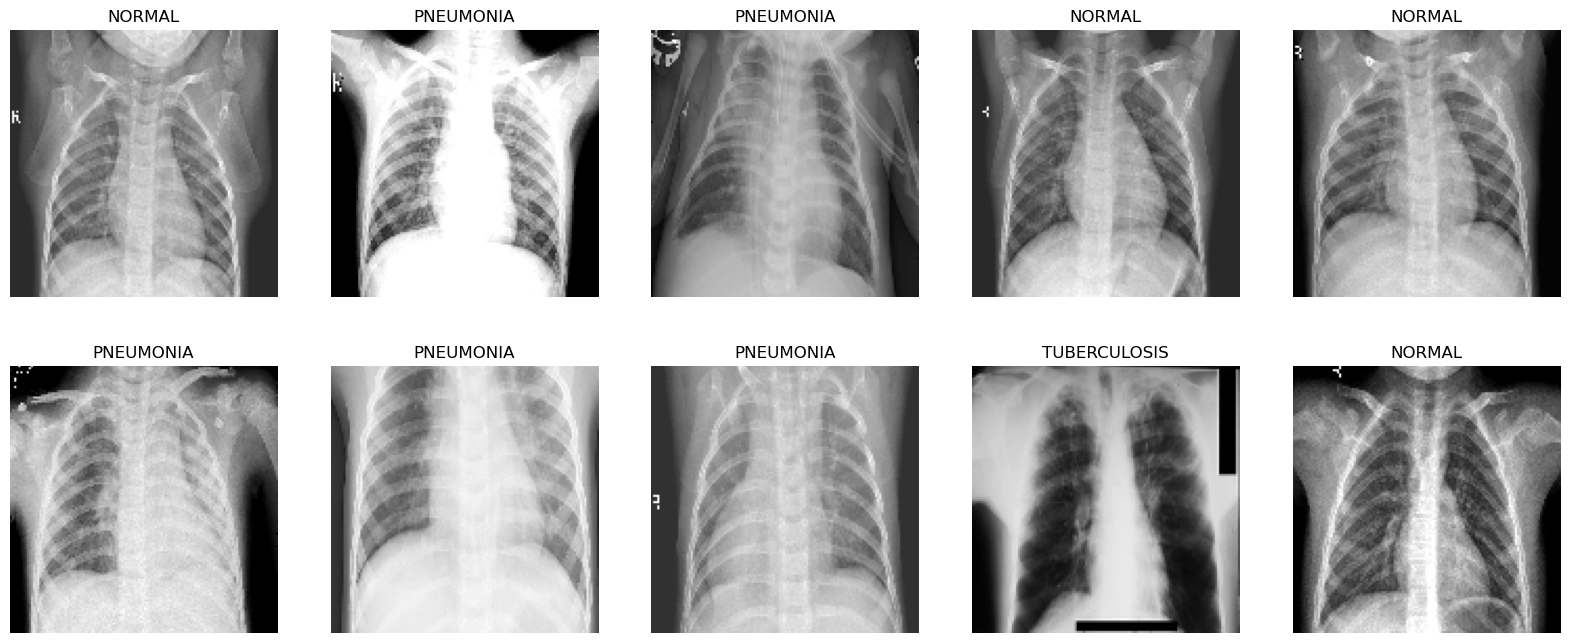

In [8]:
def open_images(paths, augment=True):
    '''
    Given a list of paths to images, this function returns the images as arrays, and conditionally augments them
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(cfg.IMAGE_SIZE,cfg.IMAGE_SIZE))
        if augment:
            image = augment_image(image)
        image = np.array(image)
        image = image/image.max()
        images.append(image)
    return np.array(images)

# Randomly select and plot a few images with augmentation
k = random.randint(0,5000)
image_paths = list(df.path[k:k+10])
labels = list(df.label[k:k+10])
images = open_images(image_paths, augment=True)

plt.rcParams.update({'font.size': 10})
fig = plt.figure(figsize=(20, 8))

for i in range(0, 10):
    fig.add_subplot(2, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(labels[i])
plt.show()

<a id="3.2"></a>
<h2 style="font-family: Verdana">3.2 <span style='color:#43B0C1; font-weight: bold;'>|</span> Label encoder-decoder</h2>  

Creating a dictionary `label_encoder` to convert string label to interger-encoded label  
And another dictionary `label_decoder` to decode the integer-encoded label

In [9]:
LABELS = ['NORMAL', 'TUBERCULOSIS', 'PNEUMONIA', 'COVID19']
label_encoder = {'NORMAL': 0, 'TUBERCULOSIS': 1, 'PNEUMONIA': 2, 'COVID19': 3}
label_decoder = {0: 'NORMAL', 1: 'TUBERCULOSIS', 2: 'PNEUMONIA', 3: 'COVID19'}

<a id="3.3"></a>
<h2 style="font-family: Verdana">3.3 <span style='color:#43B0C1; font-weight: bold;'>|</span> Train-Val Split</h2>  

Here I am splitting the dataset, 80% for training & 20% for validation  
You can change the percentage of samples for training and validation in the configuration section  

In [10]:
df_train = df[:int(cfg.TRAIN_VAL_SPLIT*len(df))]
df_val = df[int(cfg.TRAIN_VAL_SPLIT*len(df)):]

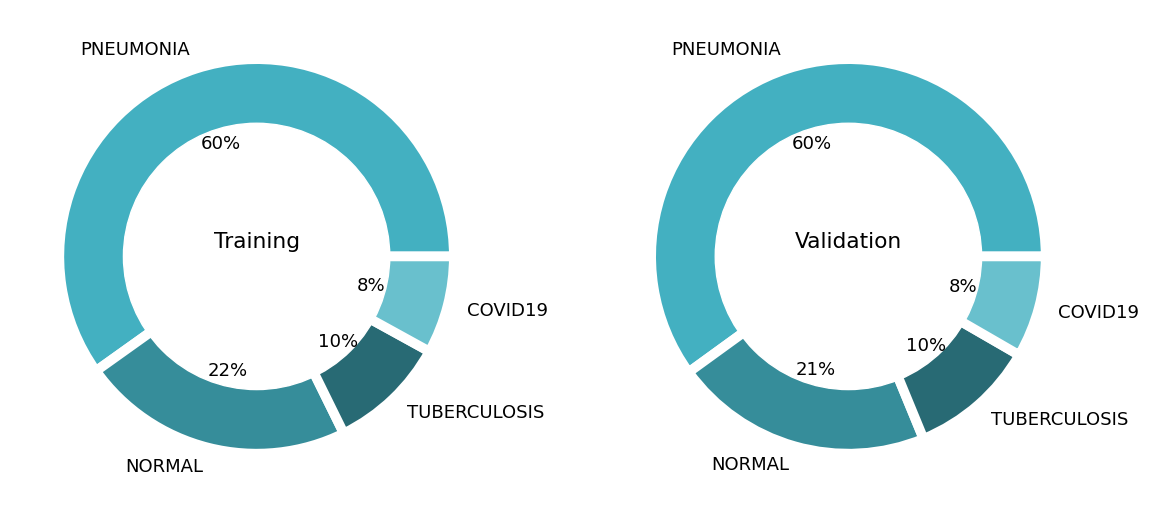

In [11]:
plt.rcParams.update({'font.size': 13})
fig = plt.figure(figsize=(14, 7))

fig.add_subplot(1, 2, 1)
plt.pie(list(df_train.label.value_counts()),
        labels=list(df_train.label.value_counts().index),
        colors=['#43b0c1', '#368d9a', '#286a74', '#69c0cd'],
        autopct='%.0f%%', wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })

my_circle=plt.Circle((0,0), 0.675, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.axis('off')
plt.title('Training', x=0.5, y=0.5) 


fig.add_subplot(1, 2, 2)
plt.pie(list(df_val.label.value_counts()),
        labels=list(df_val.label.value_counts().index),
        colors=['#43b0c1', '#368d9a', '#286a74', '#69c0cd'],
        autopct='%.0f%%', wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })

my_circle=plt.Circle((0,0), 0.675, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.axis('off')
plt.title('Validation', x=0.5, y=0.5) 

plt.show()

Training a model on this <b><mark>highly imbalanced</mark></b> dataset will cause the model to <b><mark>overfit</mark></b> on the class that is in excess and fail to learn patterns from other classes. Fortunately, there are ways to tackle this problem. What we will be doing is assigning "class weights" to the classes. We will be discussing about this later.

<a id="3.4"></a>
<h2 style="font-family: Verdana">3.4 <span style='color:#43B0C1; font-weight: bold;'>|</span> Data Generators</h2>  

`data_generator` is the generator function which we will use for training. It has 4 input parameters:
- `df`: This is the dataframe containing the image paths and labels
- `batch_size` (int): Batch size of training samples
- `augment` (boolean): If true, the augmentation techniques defined before will be applied to the images. We will set this to `True` during training and `False` during validation
- `epochs` (int): Number of epochs

In [12]:
def data_generator(df, batch_size=cfg.BATCH_SIZE, augment=True, epochs=cfg.EPOCHS):
    for e in range(epochs):
        for x in range(0,len(df), batch_size):
            image_paths = df.path[x:x+batch_size]
            images = open_images(image_paths, augment=augment)
            labels = df.label[x:x+batch_size]
            labels = [label_encoder[label] for label in labels]
            yield images, np.array(labels)

In [13]:
# Creating generators for training and validation. You can change the parameters in the configuration section.
train_data_generator = data_generator(df_train, batch_size=cfg.BATCH_SIZE, augment=True, epochs=cfg.EPOCHS)
train_steps = int(len(df_train)/cfg.BATCH_SIZE)

val_data_generator = data_generator(df_val, batch_size=cfg.BATCH_SIZE, augment=False, epochs=cfg.EPOCHS)
val_steps = int(len(df_val)/cfg.BATCH_SIZE)

<a id="4"></a>
# <b style="font-family: Verdana">4 <span style='color:#43B0C1'>|</span> MODEL</b>

<a id="4.1"></a>
<h2 style="font-family: Verdana">4.1 <span style='color:#43B0C1; font-weight: bold;'>|</span> Build</h2>  
Model Architecture inspired by <a href="https://keras.io/api/applications/vgg/"><b>VGG16</b></a> 

In [14]:
model = models.Sequential(name='classifier')
model.add(layers.Input(shape=(cfg.IMAGE_SIZE, cfg.IMAGE_SIZE, 3), name='input'))
model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same', name='block1_conv1'))
model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same', name='block1_conv2'))
model.add(layers.MaxPool2D(pool_size=(2,2), name='pool1'))
model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same', name='block2_conv1'))
model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same', name='block2_conv2'))
model.add(layers.MaxPool2D(pool_size=(2,2), name='pool2'))
model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same', name='block3_conv1'))
model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same', name='block3_conv2'))
model.add(layers.MaxPool2D(pool_size=(2,2), name='pool3'))
model.add(layers.Flatten(name='flatten'))
model.add(layers.Dropout(0.3, name='dropout1'))
model.add(layers.Dense(128, activation='relu', name='dense1'))
model.add(layers.Dense(4, activation='softmax', name='final'))

model.summary()

Model: "classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 128, 128, 32)      896       
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 32)      9248      
                                                                 
 pool1 (MaxPooling2D)        (None, 64, 64, 32)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 64)        18496     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 pool2 (MaxPooling2D)        (None, 32, 32, 64)        0         
                                                                 
 block3_conv1 (Conv2D)       (None, 32, 32, 128)       7

In [15]:
model.compile(optimizer=optimizers.Adam(learning_rate=cfg.LEARNING_RATE),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

<a id="4.3"></a>
<h2 style="font-family: Verdana">4.3 <span style='color:#43B0C1; font-weight: bold;'>|</span> Train</h2>  

As said earlier, we will be using 'class weights' to tackle the imbalanced dataset problem. Using the cross-entropy loss function will create a bias towards the dominating class. So, we will apply multipliers, or 'weights' to balance the loss function. This is called a <b><mark>weighted loss function</mark></b>:  
$$\mathcal{L}_{cross-entropy} = -\cfrac{1}{N}\sum_{i=1}^N [w_p y_i\text{log}(\hat y_i) + w_n (1-y_i)\text{log}(1-\hat y_i)]$$

So how do you calculate these so called weights $w_p$ and $w_n$ for each class? Just calculate the proportion of the dataset each class represents and tensorflow will handle the rest.  
`class_weights` is a dictionary of format `{'CLASS':'PROPORTION'}`

In [16]:
class_weights = (df_train.label.value_counts() / len(df_train)).to_dict()
class_weights = dict((label_encoder[key], value) for (key, value) in class_weights.items())
class_weights

{2: 0.5986334968465312,
 0: 0.22424667133847231,
 1: 0.09705676243868255,
 3: 0.08006306937631394}

For training, we're using the data generators previously defined and you can change the parameters of training in the configuration section.  
I'm training for 13 epochs with a batch size of 8, and using a callback function to save only the model with the highest 'val_accuracy'

<a id="4.4"></a>
<h2 style="font-family: Verdana">4.4 <span style='color:#43B0C1; font-weight: bold;'>|</span> Evaluate</h2>  

In [17]:
val_data_generator = data_generator(df_val, batch_size=cfg.BATCH_SIZE, augment=False, epochs=1)
val_steps = int(len(df_val)/cfg.BATCH_SIZE)

y_pred = []
y_true = []

for x,y in tqdm(val_data_generator, total=val_steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in pred:
        y_pred.append(label_decoder[i])
    for i in y:
        y_true.append(label_decoder[i])
clear_output()
print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

     COVID19     0.0000    0.0000    0.0000       119
      NORMAL     0.0000    0.0000    0.0000       303
   PNEUMONIA     0.6908    0.6028    0.6438       856
TUBERCULOSIS     0.2015    0.9195    0.3305       149

    accuracy                         0.4576      1427
   macro avg     0.2231    0.3806    0.2436      1427
weighted avg     0.4354    0.4576    0.4207      1427



C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



<a id="5"></a>
# <b style="font-family: Verdana">5 <span style='color:#43B0C1'>|</span> INFERENCE & DEPLOYMENT</b>  



1/1 [==============================] - 0s 288ms/step


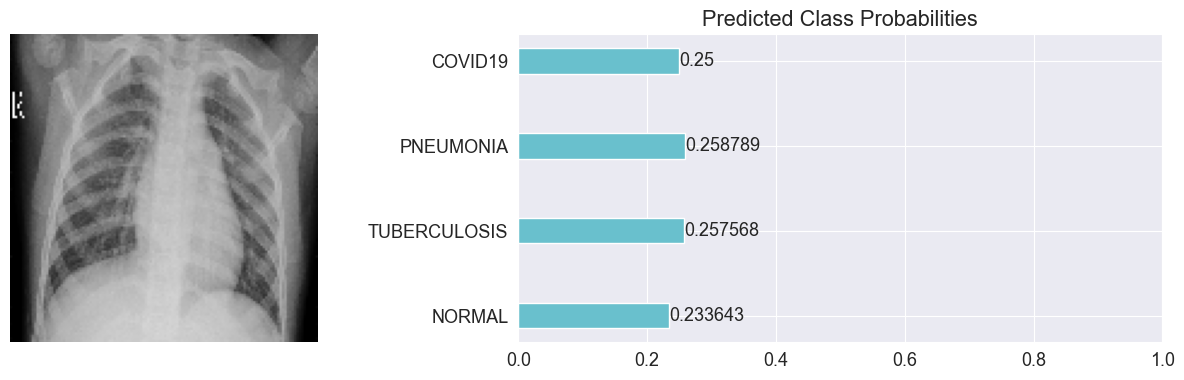

Actual   : PNEUMONIA
Predicted: PNEUMONIA
--------------------------------------------------------------------------------


1/1 [==============================] - 0s 318ms/step


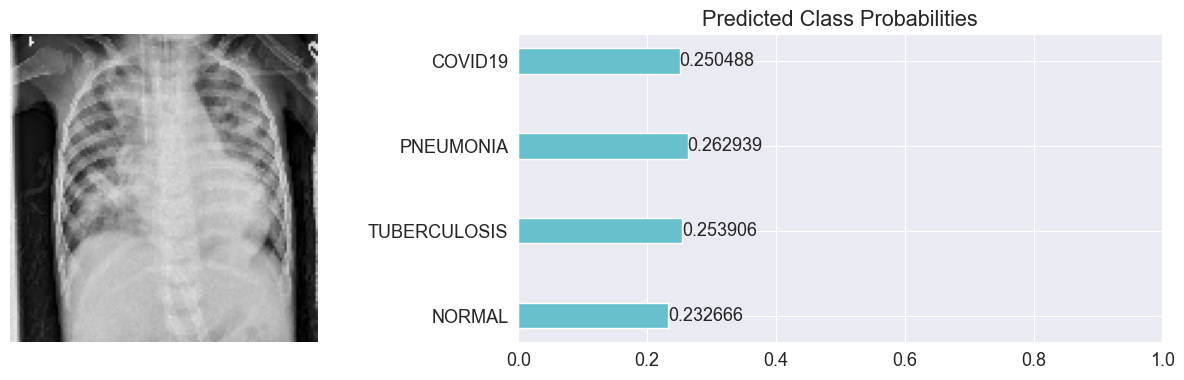

Actual   : PNEUMONIA
Predicted: PNEUMONIA
--------------------------------------------------------------------------------


1/1 [==============================] - 0s 297ms/step


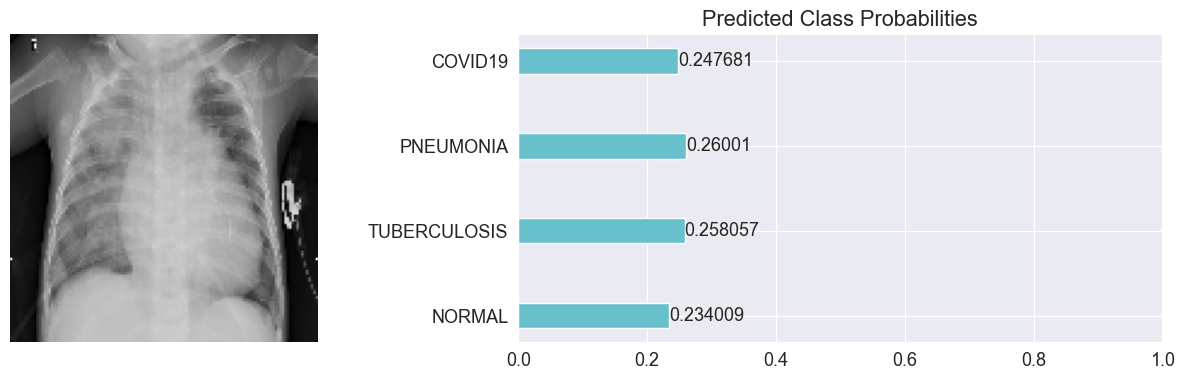

Actual   : PNEUMONIA
Predicted: PNEUMONIA
--------------------------------------------------------------------------------


1/1 [==============================] - 0s 280ms/step


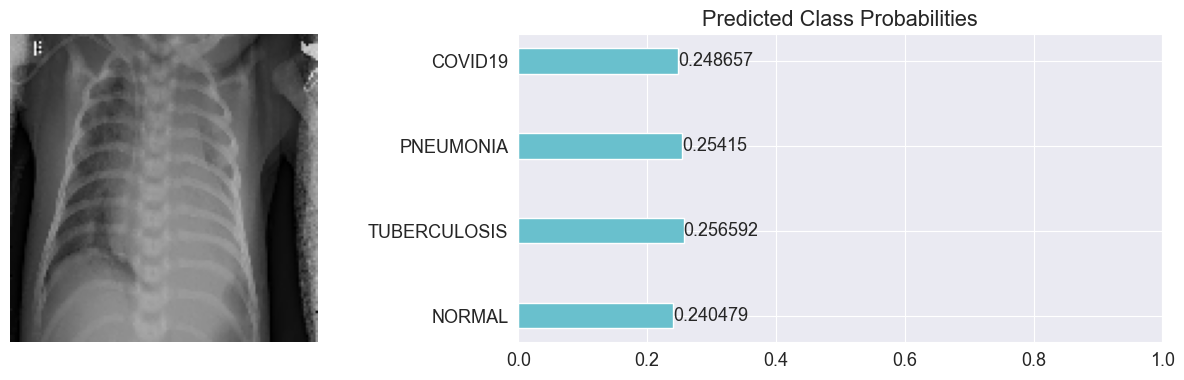

Actual   : PNEUMONIA
Predicted: TUBERCULOSIS
--------------------------------------------------------------------------------


1/1 [==============================] - 0s 298ms/step


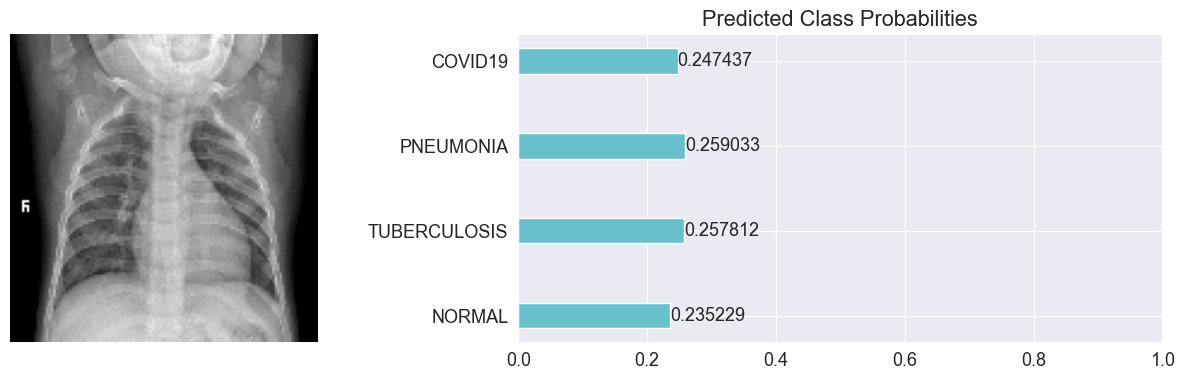

Actual   : NORMAL
Predicted: PNEUMONIA
--------------------------------------------------------------------------------


1/1 [==============================] - 0s 293ms/step


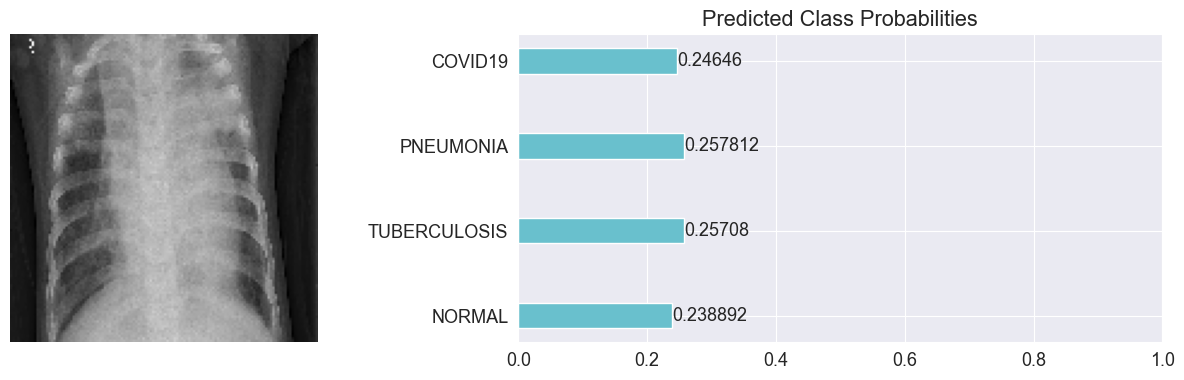

Actual   : PNEUMONIA
Predicted: PNEUMONIA
--------------------------------------------------------------------------------


1/1 [==============================] - 0s 297ms/step


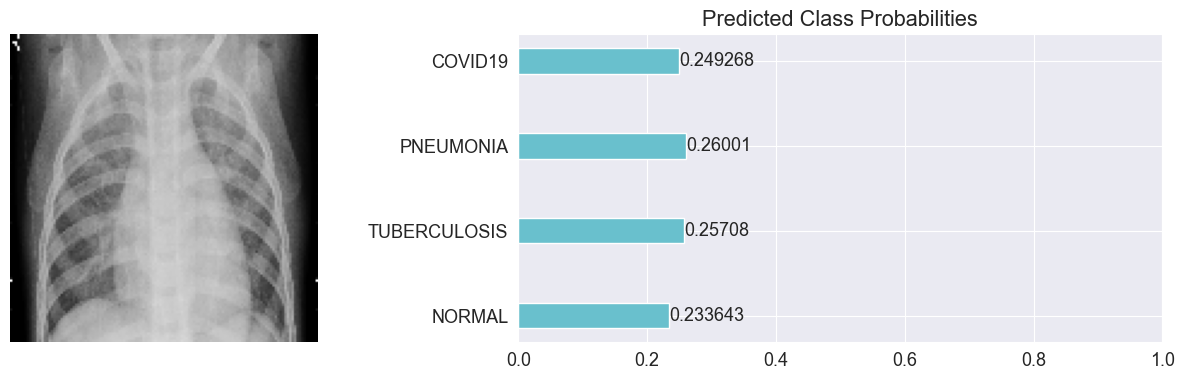

Actual   : PNEUMONIA
Predicted: PNEUMONIA
--------------------------------------------------------------------------------




In [18]:
def predict(image, model):
    '''
    Input the image and model, this function outputs the prediction as:
        1. The class with the highest probability
        2. A dictionary containing each class with their corresponding probability
    '''
    labels = ['NORMAL', 'TUBERCULOSIS', 'PNEUMONIA', 'COVID19']
    image = np.array(image)
    image = image/image.max()
    image = image.reshape(-1,cfg.IMAGE_SIZE,cfg.IMAGE_SIZE,3)
    probabilities = model.predict(image).reshape(-1)
    pred = labels[np.argmax(probabilities)]
    return pred, {x:y for x,y in zip(labels, probabilities)}

INDICES = random.sample(list(df.index), 7)

for INDEX in INDICES:

    image = load_img(df.path[INDEX], target_size=(cfg.IMAGE_SIZE, cfg.IMAGE_SIZE))
    pred, probabilities = predict(image, model)

    x = list(probabilities.keys())
    y = list(probabilities.values())

    sns.set_style("darkgrid")
    fig, ax = plt.subplots(1,2, figsize=(16,4), gridspec_kw={'width_ratios': [3, 4]})
    ax[0].imshow(image)
    ax[0].axis('off')

    bars = ax[1].barh(x, y, height=0.3, color=['#69c0cd', '#69c0cd', '#69c0cd', '#69c0cd'])
    ax[1].bar_label(bars)
    
    ax[1].set_title('Predicted Class Probabilities')
    plt.xlim([0, 1])
    plt.show()

    print('Actual   :',df.label[INDEX])
    print('Predicted:', pred)
    print('-'*80)
    print('\n')

In [19]:
df_train = df[:int(cfg.TRAIN_VAL_SPLIT*len(df))]
df_val = df[int(cfg.TRAIN_VAL_SPLIT*len(df)):]

In [20]:
import gradio as gr
import tensorflow as tf
import cv2
import numpy as np
from skimage import exposure

# Load the pre-trained model
model = tf.keras.models.load_model("C:\\Users\\acer\\OneDrive\\Desktop\\archive\\model.hdf5")

# Define the labels for classification
labels = ['NORMAL', 'TUBERCULOSIS', 'PNEUMONIA', 'COVID19']

# Function to predict label given an image
def predict(input_image):
    img_4d=input_image.reshape(-1,128,128,3)/255.0
    print(img_4d.min())
    print(img_4d.max())
    prediction=model.predict(img_4d)[0]
    return {LABELS[i]: float(prediction[i]) for i in range(4)}

def noise_filter(input_image):
    image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
    denoised_image = cv2.medianBlur(image, 3)
    equalized_image = exposure.equalize_hist(denoised_image)
    blurred_image = cv2.GaussianBlur(equalized_image, (3, 3), 0)
    sharpened_image = cv2.addWeighted(equalized_image, 1.5, blurred_image, -0.5, 0)
    # Normalize the image to the range [-1, 1]

    normalized_image = (sharpened_image - sharpened_image.min()) / (sharpened_image.max() - sharpened_image.min())
    
    resized_image = cv2.resize(normalized_image, (200, 200))
    
    return resized_image
#     return normalized_image

# Set up the Gradio interface
inputs = gr.inputs.Image(shape=(128, 128))
outputs = gr.outputs.Label(num_top_classes=4)
# filtered_image = gr.outputs.Image(type="numpy",label="Filtered Image")


filtered_image = gr.outputs.Image(type="numpy", label="Filtered Image")

interface = gr.Interface(predict, inputs=inputs, outputs=outputs)
interface1 = gr.Interface(noise_filter, inputs=inputs, outputs=filtered_image)

demo1= gr.Parallel(interface,interface1)

# interface.launch()
demo1.launch(share=True)

C:\Users\acer\AppData\Local\Temp\ipykernel_8120\329235059.py:37: GradioDeprecationWarning:

Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components

C:\Users\acer\AppData\Local\Temp\ipykernel_8120\329235059.py:37: GradioDeprecationWarning:

`optional` parameter is deprecated, and it has no effect

C:\Users\acer\AppData\Local\Temp\ipykernel_8120\329235059.py:38: GradioDeprecationWarning:

Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components

C:\Users\acer\AppData\Local\Temp\ipykernel_8120\329235059.py:38: GradioUnusedKwargWarning:

You have unused kwarg parameters in Label, please remove them: {'type': 'auto'}

C:\Users\acer\AppData\Local\Temp\ipykernel_8120\329235059.py:42: GradioDeprecationWarning:

Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components



Running on local URL:  http://127.0.0.1:7860


OSError: [WinError 225] Operation did not complete successfully because the file contains a virus or potentially unwanted software: 'C:\\Users\\acer\\AppData\\Roaming\\Python\\Python310\\site-packages\\gradio\\frpc_windows_amd64_v0.2'

0.0
0.996078431372549
1/1 [==============================] - 1s 534ms/step
